# LGBM Classifier

### Data Preprocessing


1) Preprocessing applied to all files: - Features with > 90% data missing or > 90% data with the same value were dropped - If possible, categorical variables with 100s of categories were mapped to coaser categoricals - Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity - https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id - Some "D" columns were normalized for time - Aggregate features were added using "magic" technique - https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works - Dropped TransactionID and TransactionDT

2) Specific preprocessing applied based on classifiers:

#### Response variable
y_train.pkl
- contains binary fraud/notfraud response for training dataset

#### cleanLGBM.zip

LGBM_{train, test}_X_1.pkl

- Full 200 features from output of 1) above
- No dummy creation
    
LGBM_{train, test}_X_2.pkl

- Removed additional features
        - Highly correlated "C", "D" features
        - Removed features Chris (1st place winners) removed
        - Removed caterogical features withh 200+ categories even after 1)
- No dummy creation
    
LGBM_{train, test}_X_3.pkl

- Exact same as LGBM_{train, test}_X_1.pkl except NAs filled with -999
    
LGBM_{train, test}_X_4.pkl

- Exact same as LGBM_{train, test}_X_2.pkl except NAs filled with -999

# # Part A: Data loading and preprocessing

In [65]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, cross_validate, KFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, make_scorer, classification_report

In [66]:
# Response isFraud for training data
trainY_data = pickle.load(open('train_y.pkl','rb'))

In [67]:
# Full 200 features with categorical features
trainX1_data = pickle.load(open('LGBM_train_X_1.pkl','rb'))

In [68]:
# Full 200 features without categorical features
trainX2_data = pickle.load(open('LGBM_train_X_2.pkl','rb'))

In [69]:
trainX1_data.shape, trainX2_data.shape, trainY_data.shape

((590540, 200), (590540, 171), (590540,))

In [70]:
trainY_data.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

### Data format conversion to LGBM 

Converting Category objects in the dataset to Category 

In [71]:
for c in trainX1_data.columns:
    col_type = trainX1_data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        trainX1_data[c] = trainX1_data[c].astype('category')
trainX1_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 200 entries, id_01 to D11_card1_addr1_P_emaildomain_std
dtypes: category(29), float32(26), float64(142), int32(2), int64(1)
memory usage: 729.4 MB


In [72]:
for c in trainX2_data.columns:
    col_type = trainX2_data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        trainX2_data[c] = trainX2_data[c].astype('category')
trainX2_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 171 entries, id_01 to D11_card1_addr1_P_emaildomain_std
dtypes: category(20), float32(26), float64(122), int32(2), int64(1)
memory usage: 633.0 MB


Fitting the base model using train_test_split. 

In [73]:
# Splitting the dataset into the Training set and Test set
seed = 123
test_size = 0.3
X1_train, X1_test, y1_train, y1_test = train_test_split(trainX1_data, trainY_data, test_size = test_size, random_state = seed)

In [74]:
# Splitting the dataset into the Training set and Test set
X2_train, X2_test, y2_train, y2_test = train_test_split(trainX2_data, trainY_data, test_size = test_size, random_state = seed)

## Part B: Hyperparameter Tuning

In [123]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize
from sklearn.model_selection import ShuffleSplit

In [124]:
# define classifier
estimator = lgb.LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        boosting_type = "gbdt",
        )

In [131]:
# define hyperparameter space
search_spaces = {
            'learning_rate': (0.01, 1.0, 'log-uniform'),
            'num_leaves': Integer(100, 700),
            'max_depth': Integer(5, 500),
            'colsample_bytree': (0.01, 1.0, 'uniform'),
            'subsample': (0.01, 1.0, 'uniform'),
            'min_data_in_leaf': Integer(5,200),
            'min_child_weight': (0.1, 10),
            'n_estimators': Integer(10, 10000),
            'reg_alpha': (1e-7, 1000, 'log-uniform'),
            'reg_lambda': (1e-7, 1000, 'log-uniform')                
    }

In [132]:
cv = ShuffleSplit(test_size=test_size,train_size = 1-test_size, n_splits=1, random_state = 123)

In [136]:
lgb_tuner = BayesSearchCV(estimator = estimator, search_spaces = search_spaces, scoring = 'roc_auc',cv = cv,  n_iter = 9, verbose =1, refit = True, random_state = seed)

In [137]:
def status_print(optim_result):    
    all_models = pd.DataFrame(lgb_tuner.cv_results_)    
    
    # Get best parameters    
    best_params = pd.Series(lgb_tuner.best_params_)
    print(f'Model {len(all_models)}:\nBest Score:\
    {np.round(lgb_tuner.best_score_, 4)}\nBestparams:{lgb_tuner.best_params_}\n')
    
    # Save to csv
    clf_name = lgb_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")  

In [138]:
result1 = lgb_tuner.fit(X1_train, y1_train,callback = status_print)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 1:
Best Score:    0.8801
Bestparams:OrderedDict([('colsample_bytree', 0.8601068320616704), ('learning_rate', 0.05435602973134512), ('max_depth', 48), ('min_child_weight', 4.688289424522031), ('min_data_in_leaf', 127), ('n_estimators', 1347), ('num_leaves', 332), ('reg_alpha', 767), ('reg_lambda', 125), ('subsample', 0.7123773547917213)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 2:
Best Score:    0.9417
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 3:
Best Score:    0.9417
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 4:
Best Score:    0.9417
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 5:
Best Score:    0.9417
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 6:
Best Score:    0.9417
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 7:
Best Score:    0.965
Bestparams:OrderedDict([('colsample_bytree', 0.7604552944997698), ('learning_rate', 0.1641655036765839), ('max_depth', 481), ('min_child_weight', 1.0184808924538276), ('min_data_in_leaf', 120), ('n_estimators', 607), ('num_leaves', 615), ('reg_alpha', 3), ('reg_lambda', 878), ('subsample', 0.7416961993621997)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 22.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 8:
Best Score:    0.965
Bestparams:OrderedDict([('colsample_bytree', 0.7604552944997698), ('learning_rate', 0.1641655036765839), ('max_depth', 481), ('min_child_weight', 1.0184808924538276), ('min_data_in_leaf', 120), ('n_estimators', 607), ('num_leaves', 615), ('reg_alpha', 3), ('reg_lambda', 878), ('subsample', 0.7416961993621997)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished


Model 9:
Best Score:    0.965
Bestparams:OrderedDict([('colsample_bytree', 0.7604552944997698), ('learning_rate', 0.1641655036765839), ('max_depth', 481), ('min_child_weight', 1.0184808924538276), ('min_data_in_leaf', 120), ('n_estimators', 607), ('num_leaves', 615), ('reg_alpha', 3), ('reg_lambda', 878), ('subsample', 0.7416961993621997)])



In [139]:
result2 = lgb_tuner.fit(X2_train, y2_train, callback = status_print)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 1:
Best Score:    0.8739
Bestparams:OrderedDict([('colsample_bytree', 0.8601068320616704), ('learning_rate', 0.05435602973134512), ('max_depth', 48), ('min_child_weight', 4.688289424522031), ('min_data_in_leaf', 127), ('n_estimators', 1347), ('num_leaves', 332), ('reg_alpha', 767), ('reg_lambda', 125), ('subsample', 0.7123773547917213)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 2:
Best Score:    0.9357
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 3:
Best Score:    0.9357
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 4:
Best Score:    0.9357
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 5:
Best Score:    0.9357
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 6:
Best Score:    0.9357
Bestparams:OrderedDict([('colsample_bytree', 0.9925929263254571), ('learning_rate', 0.33587374758460675), ('max_depth', 419), ('min_child_weight', 0.33436455315174696), ('min_data_in_leaf', 101), ('n_estimators', 1830), ('num_leaves', 469), ('reg_alpha', 57), ('reg_lambda', 873), ('subsample', 0.6538516484960257)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 7:
Best Score:    0.9621
Bestparams:OrderedDict([('colsample_bytree', 0.7604552944997698), ('learning_rate', 0.1641655036765839), ('max_depth', 481), ('min_child_weight', 1.0184808924538276), ('min_data_in_leaf', 120), ('n_estimators', 607), ('num_leaves', 615), ('reg_alpha', 3), ('reg_lambda', 878), ('subsample', 0.7416961993621997)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model 8:
Best Score:    0.9621
Bestparams:OrderedDict([('colsample_bytree', 0.7604552944997698), ('learning_rate', 0.1641655036765839), ('max_depth', 481), ('min_child_weight', 1.0184808924538276), ('min_data_in_leaf', 120), ('n_estimators', 607), ('num_leaves', 615), ('reg_alpha', 3), ('reg_lambda', 878), ('subsample', 0.7416961993621997)])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished


Model 9:
Best Score:    0.9621
Bestparams:OrderedDict([('colsample_bytree', 0.7604552944997698), ('learning_rate', 0.1641655036765839), ('max_depth', 481), ('min_child_weight', 1.0184808924538276), ('min_data_in_leaf', 120), ('n_estimators', 607), ('num_leaves', 615), ('reg_alpha', 3), ('reg_lambda', 878), ('subsample', 0.7416961993621997)])



In [140]:
result1.cv_results_

defaultdict(list,
            {'split0_test_score': [0.8738831502565162,
              0.9356984416086563,
              0.9079886825958965,
              0.8806210369175312,
              0.8807257927733282,
              0.9246831274504905,
              0.9621497628318703,
              0.8761016434950766,
              0.8857882503754273],
             'mean_test_score': [0.8738831502565162,
              0.9356984416086563,
              0.9079886825958965,
              0.8806210369175312,
              0.8807257927733282,
              0.9246831274504905,
              0.9621497628318703,
              0.8761016434950766,
              0.8857882503754273],
             'std_test_score': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             'rank_test_score': [9, 2, 4, 7, 6, 3, 1, 8, 5],
             'mean_fit_time': [234.39672303199768,
              359.49356269836426,
              63.86252689361572,
              411.11548805236816,
              363.664026260376,
     

In [141]:
result2.cv_results_

defaultdict(list,
            {'split0_test_score': [0.8738831502565162,
              0.9356984416086563,
              0.9079886825958965,
              0.8806210369175312,
              0.8807257927733282,
              0.9246831274504905,
              0.9621497628318703,
              0.8761016434950766,
              0.8857882503754273],
             'mean_test_score': [0.8738831502565162,
              0.9356984416086563,
              0.9079886825958965,
              0.8806210369175312,
              0.8807257927733282,
              0.9246831274504905,
              0.9621497628318703,
              0.8761016434950766,
              0.8857882503754273],
             'std_test_score': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             'rank_test_score': [9, 2, 4, 7, 6, 3, 1, 8, 5],
             'mean_fit_time': [234.39672303199768,
              359.49356269836426,
              63.86252689361572,
              411.11548805236816,
              363.664026260376,
     

In [142]:
params1 = result1.best_params_
params1

OrderedDict([('colsample_bytree', 0.7604552944997698),
             ('learning_rate', 0.1641655036765839),
             ('max_depth', 481),
             ('min_child_weight', 1.0184808924538276),
             ('min_data_in_leaf', 120),
             ('n_estimators', 607),
             ('num_leaves', 615),
             ('reg_alpha', 3),
             ('reg_lambda', 878),
             ('subsample', 0.7416961993621997)])

In [143]:
params2 = result2.best_params_
params2

OrderedDict([('colsample_bytree', 0.7604552944997698),
             ('learning_rate', 0.1641655036765839),
             ('max_depth', 481),
             ('min_child_weight', 1.0184808924538276),
             ('min_data_in_leaf', 120),
             ('n_estimators', 607),
             ('num_leaves', 615),
             ('reg_alpha', 3),
             ('reg_lambda', 878),
             ('subsample', 0.7416961993621997)])

In [144]:
'''
OrderedDict([('colsample_bytree', 0.7604552944997698),
             ('learning_rate', 0.1641655036765839),
             ('max_depth', 481),
             ('min_child_weight', 1.0184808924538276),
             ('min_data_in_leaf', 117),
             ('n_estimators', 607),
             ('num_leaves', 615),
             ('reg_alpha', 3),
             ('reg_lambda', 878),
             ('subsample', 0.7416961993621997)])
'''

"\nOrderedDict([('colsample_bytree', 0.7604552944997698),\n             ('learning_rate', 0.1641655036765839),\n             ('max_depth', 481),\n             ('min_child_weight', 1.0184808924538276),\n             ('min_data_in_leaf', 117),\n             ('n_estimators', 607),\n             ('num_leaves', 615),\n             ('reg_alpha', 3),\n             ('reg_lambda', 878),\n             ('subsample', 0.7416961993621997)])\n"

## Part C: Retrain model on entire training data (A) and apply on validation data (B)

Build Model

In [145]:
%%time
x1_model = lgb.LGBMClassifier(metric='auc', objective = 'binary', boosting_type = 'gbdt',  
             colsample_bytree = params['colsample_bytree'],
             learning_rate = params['learning_rate'],
             max_depth = params['max_depth'],
             min_child_weight = params['min_child_weight'],
             min_data_in_leaf = params['min_data_in_leaf'],
             n_estimators = params['n_estimators'],
             num_leaves = params['num_leaves'],
             reg_alpha = params['reg_alpha'],
             reg_lambda = params['reg_lambda'],
             subsample = params['subsample'])                     
x1_model.fit(X1_train, y1_train)
print("Tuned model 1 is fitted")

Tuned model 1 is fitted
Wall time: 10min 23s
Parser   : 201 ms


In [146]:
%%time
x2_model = lgb.LGBMClassifier(metric='auc', objective = 'binary', boosting_type = 'gbdt',  
             colsample_bytree = params['colsample_bytree'],
             learning_rate = params['learning_rate'],
             max_depth = params['max_depth'],
             min_child_weight = params['min_child_weight'],
             min_data_in_leaf = params['min_data_in_leaf'],
             n_estimators = params['n_estimators'],
             num_leaves = params['num_leaves'],
             reg_alpha = params['reg_alpha'],
             reg_lambda = params['reg_lambda'],
             subsample = params['subsample'])                     
x2_model.fit(X2_train, y2_train)
print("Tuned model 2 is fitted")

Tuned model 2 is fitted
Wall time: 8min 31s


##### Test model and report performance metrics

In [147]:
%%time
x1_y_pred = x1_model.predict_proba(X1_test)[:, 1]
auc_score1 = roc_auc_score(y1_test, x1_y_pred)
print(f"ROC_AUC score for X1: {auc_score1* 100:.2f}%")
x1_frp, x1_tpr, _ = roc_curve(y1_test, x1_y_pred)

ROC_AUC score for X1: 96.95%
Wall time: 1min 11s
Parser   : 151 ms


In [148]:
%%time
x2_y_pred = x2_model.predict_proba(X2_test)[:, 1]
auc_score2 = roc_auc_score(y2_test, x2_y_pred)
print(f"ROC_AUC score for X2: {auc_score2* 100:.2f}%")
x2_frp, x2_tpr, _ = roc_curve(y2_test, x2_y_pred)

ROC_AUC score for X2: 96.73%
Wall time: 1min 6s
Parser   : 469 ms


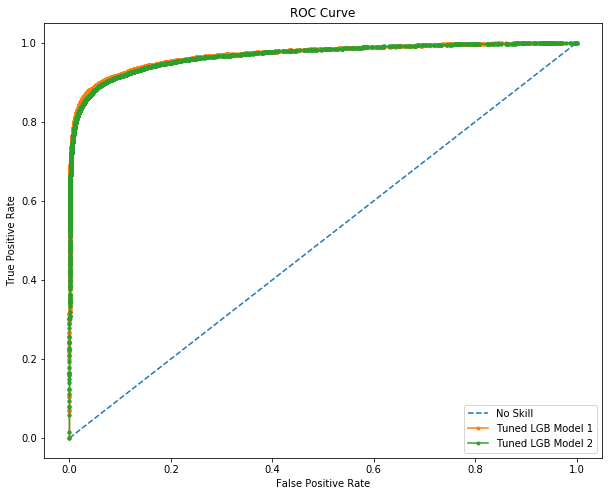

In [149]:
# Define true-positive and false-positive for no skill predictions
no_skill_pred = [0 for _ in range(len(y1_test))]
ns_frp, ns_tpr, _ = roc_curve(y1_test, no_skill_pred)

# Plot ROC curve across models
plt.figure(figsize=(10, 8))
plt.plot(ns_frp, ns_tpr, linestyle = '--', label='No Skill')
plt.plot(x1_frp, x1_tpr, marker = '.', label='Tuned LGB Model 1')
plt.plot(x2_frp, x2_tpr, marker = '.', label='Tuned LGB Model 2')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.legend(loc="lower right")
plt.savefig('LGBM ROC Curve.png')
plt.show()

In [150]:
#Confusion matrix
print("Model 1")

for i in range(len(x1_y_pred)):
    if x1_y_pred[i]>=.5:       # setting threshold to .5
        x1_y_pred[i]=1
    else:  
        x1_y_pred[i]=0

cm = confusion_matrix(y1_test, x1_y_pred)
print("Confusion matrix",cm)

#Accuracy
accuracy=accuracy_score(x1_y_pred,y1_test)
print(f"Accuracy score: {accuracy* 100:.2f}%")

#Scores
print("Report")
print(classification_report(x1_y_pred,y1_test))

Model 1
Confusion matrix [[170780    216]
 [  2206   3960]]
Accuracy score: 98.63%
Report
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    172986
         1.0       0.64      0.95      0.77      4176

    accuracy                           0.99    177162
   macro avg       0.82      0.97      0.88    177162
weighted avg       0.99      0.99      0.99    177162



In [151]:
#Confusion matrix
print("Model 2")

for i in range(len(x2_y_pred)):
    if x2_y_pred[i]>=.5:       # setting threshold to .5
        x2_y_pred[i]=1
    else:  
        x2_y_pred[i]=0

cm = confusion_matrix(y2_test, x2_y_pred)
print("Confusion matrix",cm)

#Accuracy
accuracy=accuracy_score(x2_y_pred,y2_test)
print(f"Accuracy score: {accuracy* 100:.2f}%")

#Scores
print("Report")
print(classification_report(x2_y_pred,y2_test))

Model 2
Confusion matrix [[170734    262]
 [  2320   3846]]
Accuracy score: 98.54%
Report
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    173054
         1.0       0.62      0.94      0.75      4108

    accuracy                           0.99    177162
   macro avg       0.81      0.96      0.87    177162
weighted avg       0.99      0.99      0.99    177162



##### Feature Importance

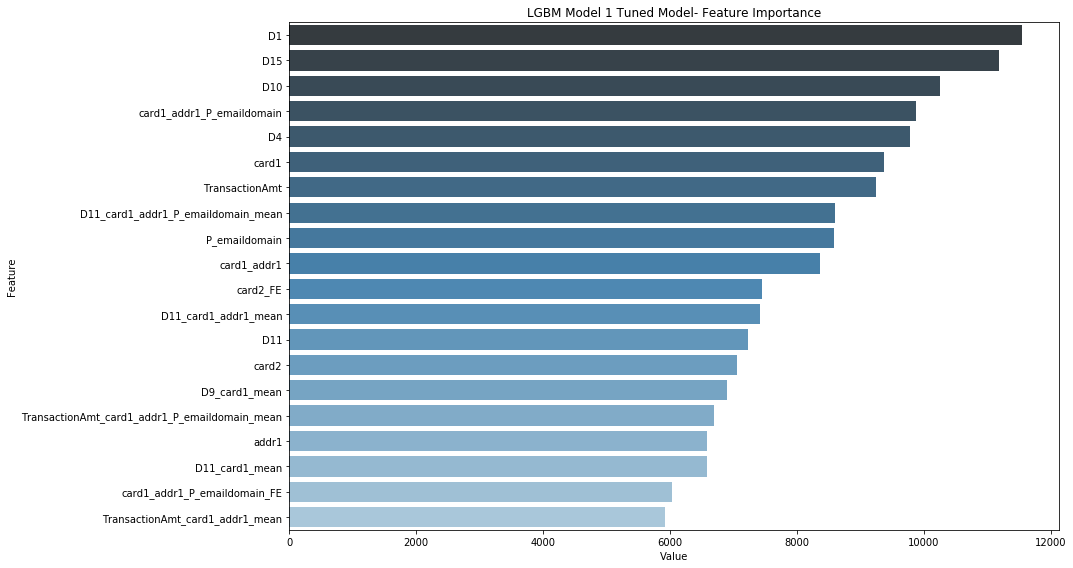

Wall time: 2.76 s


In [152]:
%%time
# Understand feature importance in the model
feature_imp1 = pd.DataFrame(sorted(zip(x1_model.feature_importances_,X1_train.columns)), columns=['Value','Feature'])
feature_imp1 = feature_imp1.sort_values(by = ['Value'], ascending = False).reset_index(drop = True)
plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp1.sort_values(by="Value", ascending=False).iloc[:20],\
            palette = "Blues_d")
plt.title('LGBM Model 1 Tuned Model- Feature Importance')
plt.savefig('LGBM Model 1 Feature Importance.png')
plt.tight_layout()
plt.show()

In [153]:
feature_imp1.head(10)

,Value,Feature
0,11551,D1
1,11188,D15
2,10259,D10
3,9877,card1_addr1_P_emaildomain
4,9792,D4
5,9368,card1
6,9247,TransactionAmt
7,8597,D11_card1_addr1_P_emaildomain_mean
8,8582,P_emaildomain
9,8371,card1_addr1


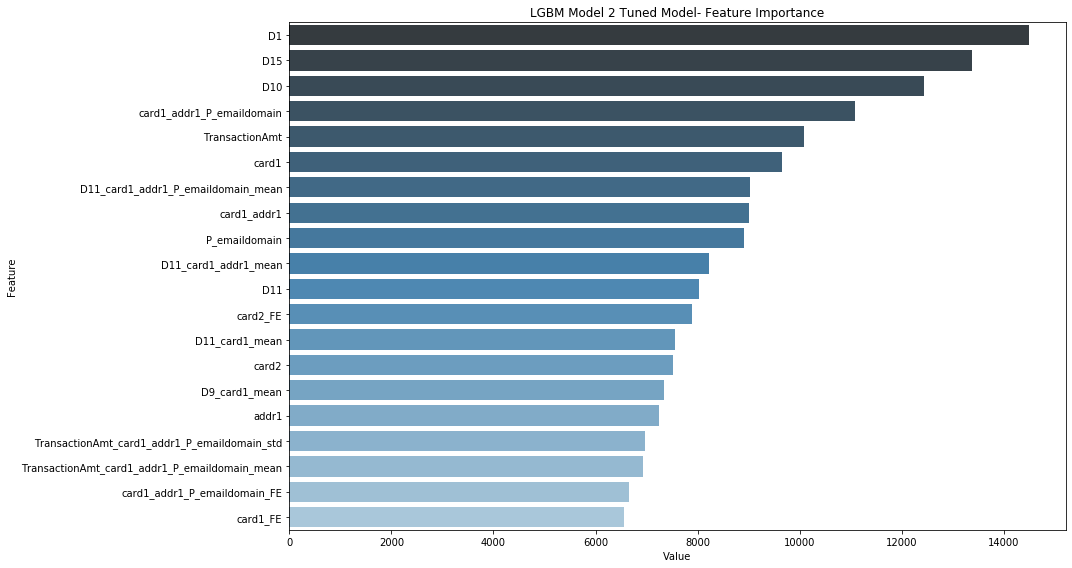

Wall time: 1.54 s


In [154]:
%%time
# Understand feature importance in the model
feature_imp2 = pd.DataFrame(sorted(zip(x2_model.feature_importances_,X2_train.columns)), columns=['Value','Feature'])
feature_imp2 = feature_imp2.sort_values(by = ['Value'], ascending = False).reset_index(drop = True)
plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp2.sort_values(by="Value", ascending=False).iloc[:20],\
            palette = "Blues_d")
plt.title('LGBM Model 2 Tuned Model- Feature Importance')
plt.savefig('LGBM Model 2 Feature Importance.png')
plt.tight_layout()
plt.show()

In [155]:
feature_imp2.head(10)

,Value,Feature
0,14487,D1
1,13385,D15
2,12432,D10
3,11086,card1_addr1_P_emaildomain
4,10094,TransactionAmt
5,9660,card1
6,9030,D11_card1_addr1_P_emaildomain_mean
7,9003,card1_addr1
8,8908,P_emaildomain
9,8229,D11_card1_addr1_mean


## Part D: Save Deliverables

We will save the following deliverables:
- Model [pkl format]
- Predicted Probability of validation data (B) [dataframe format]
- Feature Importance [dataframe format]
- ROC curve [png]
- Feature Importance [png]

In [156]:
# Save predicted data:
# 1) Model// To load model: rf_tuned = joblib.load('TunedLGBMModel1.pkl') // joblib.load('TunedLGBMModel2.pkl')
joblib.dump(x1_model, 'TunedLGBMModel1.pkl')
joblib.dump(x2_model, 'TunedLGBMModel2.pkl')

# 2) Dataframe data// To load data: feature_imp = pd.read_pickle("RF_feature_importance.pkl")
feature_imp1.to_pickle("LGBM_Model1_feature_importance.pkl")
feature_imp2.to_pickle("LGBM_Model2_feature_importance.pkl")

# 3) Numpy data// To load data: y_B_pred_prob = np.load('RF_y_B_pred_prob.npy') 
validation_results1 = pd.DataFrame(zip(y1_test, x1_y_pred), columns=['True Label','Predicted Label'])
validation_results2 = pd.DataFrame(zip(y2_test, x2_y_pred), columns=['True Label','Predicted Label'])
validation_results1.to_pickle("LGBM_Model1_validation_results.pkl")
validation_results2.to_pickle("LGBM_Model2_validation_results.pkl")
validation_results1.head()
validation_results2.head()

,True Label,Predicted Label
0,0,0.0
1,0,0.0
2,1,1.0
3,0,0.0
4,0,0.0
